In [1]:
%cd ..

C:\Users\Dmytro_Shvetsov\Desktop\super-resolution-engine


In [2]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

tf.debugging.set_log_device_placement(False)

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

dry_run = False

In [3]:
import tensorflow as tf 
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

True
[]


In [4]:
def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save(f'{filename}.jpg')
    print(f'Saved as {filename}.jpg')

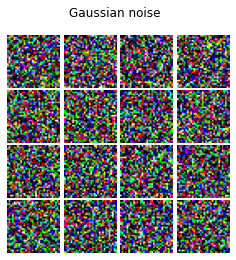

In [5]:
from utils import plot_multiple_images, plot_single_image


plot_multiple_images(tf.random.normal((2, 16, 32, 32, 3)) * 255, 'Gaussian noise')

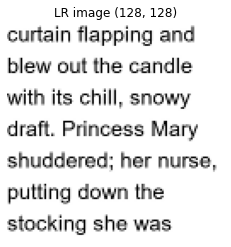

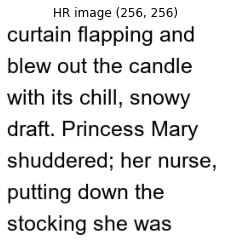

In [6]:
from esrgan import ESRGAN
from os import path
from data import CLEAR_IMAGES_DIR, get_dataset


# ds_iter = 

# model = ESRGAN()
# model.load()

# for i in range(3):
X, y = next(iter(get_dataset(path.join(CLEAR_IMAGES_DIR, 'train')).batch(1)))
#     enhanced_batch = model(X)
# plot_multiple_images([tf.expand_dims(X[0], axis=0), tf.expand_dims(X[1], axis=0)], 'Enhanced vs groud truth HR images', cmap='gray', figsize=(6, 6))
plot_single_image(X[0], 'LR image (128, 128)')
plt.figure()
plot_single_image(y[0], 'HR image (256, 256)')

In [9]:
# from core.pan import PixelAttentionSRNetwork
from itertools import cycle

    
# # b = SCPA(3)
# # b(tf.ones((8, 64, 64, 3))).shape
batch_size = 32
inp_shape = (batch_size, 64, 64, 3)
# net = PixelAttentionSRNetwork(feat_extr_n_filters=30, upsamp_n_filters=20, n_blocks=16, scale=4, input_shape=inp_shape)
# net.build(inp_shape)
# # print(net(tf.ones(inp_shape)).shape)
# net.summary()

In [12]:
# t = time.time()
# net(tf.ones(inp_shape))

# print('Single forward step for PAN took', time.time() - t) # 3.076345920562744

In [14]:
from os import path
from data import CLEAR_IMAGES_DIR, LR_IMAGE_SIZE, HR_IMAGE_SIZE
from utils import plot_multiple_images, plot_single_image
from core.pan import PixelAttentionSRNetwork
from itertools import cycle


input_lr_shape = (None, *LR_IMAGE_SIZE, 3)
input_hr_shape = (None, *HR_IMAGE_SIZE, 3)

cpu = '/CPU:0'
# gpu = '/GPU:0'

device = cpu

max_ckpt_to_keep = 3
checkpoint_dir = './model/x2_checkpoints'
checkpoint_name = 'pix-att-net-ckpt'


with tf.device(device):
    test_dataset = cycle(get_dataset(path.join(CLEAR_IMAGES_DIR, 'train')).batch(4))
    
    sr_net = PixelAttentionSRNetwork(input_lr_shape, feat_extr_n_filters=30, upsamp_n_filters=20, n_blocks=16, scale=2)
    
    checkpoint = tf.train.Checkpoint(sr_net=sr_net)

    sr_net.build(input_lr_shape)

    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_ckpt_to_keep, checkpoint_name=checkpoint_name)

    # try restoring previous checkpoint or initialize a new one
    restored_ckpt_path = ckpt_manager.restore_or_initialize()
    if restored_ckpt_path:
        print('Restored state from checkpoint {}'.format(repr(restored_ckpt_path)))



Restored state from checkpoint './model/x2_checkpoints\\pix-att-net-ckpt-139'


Max possible psnr inf


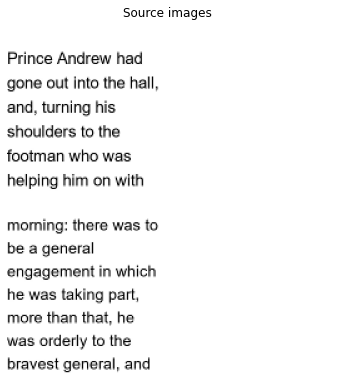

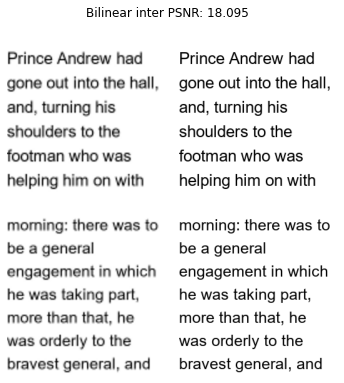

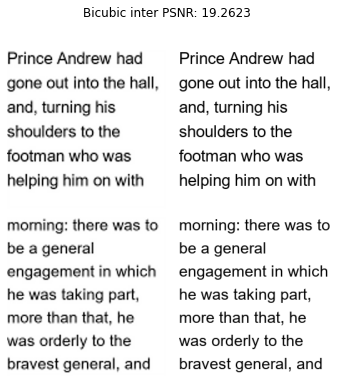

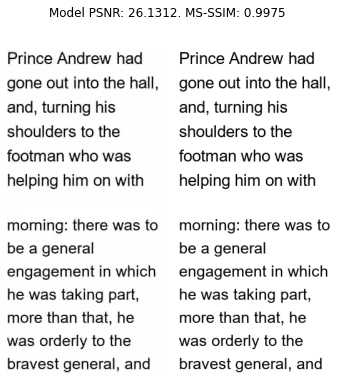

In [15]:
X, y = next(test_dataset)
plot_multiple_images([X, np.ones(X.shape) * 255], figsize=(6, 6), title=f'Source images')

print('Max possible psnr', round(float(tf.reduce_mean(tf.image.psnr(y, y, 255))), 4))

y_hat = tf.image.resize(X, HR_IMAGE_SIZE, method='bilinear')
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bilinear inter PSNR: {psnr}')
# plot_multiple_images([y_hat, y], figsize=(6, 6))
# plt.savefig('./x4/bilinear_inter_results.png')


y_hat = tf.image.resize(X, HR_IMAGE_SIZE, method='bicubic')
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bicubic inter PSNR: {psnr}')
# plot_multiple_images([y_hat, y], figsize=(6, 6))
# plt.savefig('./x4/bicubic_inter_results.png')

y_hat = tf.clip_by_value(sr_net(X, training=False), 0, 255)
psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
msssim = round(float(tf.reduce_mean(tf.image.ssim_multiscale(y_hat, y, 255))), 4)
# print(msssim)
plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Model PSNR: {psnr}. MS-SSIM: {msssim}')
# plot_multiple_images([y_hat, y], figsize=(6, 6))
# plt.savefig('./x4/sr_model_inter_results.png')

# model = ESRGAN()
# model.load()

# y_hat = tf.clip_by_value(model(X), 0, 255)
# psnr = round(float(tf.reduce_mean(tf.image.psnr(y, y_hat, 255))), 4)
# plot_multiple_images([y_hat, y], figsize=(6, 6), title=f'Bilinear inter PSNR: {psnr}')

In [16]:
# psnr_test_model = gen
from functools import partial

# psnr_test_model = partial(tf.image.resize, size=HR_IMAGE_SIZE, method='bilinear')
# psnr_test_model = partial(tf.image.resize, size=HR_IMAGE_SIZE, method='bicubic')
psnr_test_model = partial(sr_net, training=False)

In [17]:
mean_batch_psnr = 0.0
mean_batch_ssim = 0.0
mean_batch_msssim = 0.0

with tf.device('/GPU:0'):
    batch_size = 50
    dataset = get_dataset(path.join(CLEAR_IMAGES_DIR, 'test'))
    n_batches = 0
    for batch_x, batch_y in dataset.batch(batch_size):
        y_hat = psnr_test_model(batch_x)
        mean_batch_psnr += tf.reduce_mean(tf.image.psnr(y_hat, batch_y, 255))
        mean_batch_ssim += tf.reduce_mean(tf.image.ssim(y_hat, batch_y, 255))
        mean_batch_msssim += tf.reduce_mean(tf.image.ssim_multiscale(y_hat, batch_y, 255))
        n_batches += 1

mean_batch_psnr /= n_batches
mean_batch_ssim /= n_batches
mean_batch_msssim /= n_batches
print('PSNR:', round(float(mean_batch_psnr), 4))
print('SSIM:', round(float(mean_batch_ssim), 4))
print('MSSSIM:', round(float(mean_batch_msssim), 4))

KeyboardInterrupt: 

In [18]:
from json import load


with open('./data/img/clear_words_coordinates.json') as fid:
    annot = load(fid)
    
list(annot.keys())[:3]

['image0', 'image1', 'image2']

In [19]:
def get_true_text(img_name):
    return ' '.join((w_st['word'] for w_st in annot[img_name])) + '\f'

repr(get_true_text('image0'))

"'Title War and Peace\\n Author: Leo Tolstoy\\n Posting Date: January\\n 10, 2009 Release Date:\\n April, 2001 Language:\\n English WAR AND\\n PEACE By Leo Tolstoy\\n\\x0c'"

In [23]:
import pytesseract as tesseract


# specify path to the preinstalled binary file of tesseract
tesseract.pytesseract.tesseract_cmd = r'C:\Users\Dmytro_Shvetsov\Desktop\tesseract\tesseract.exe'
print('Tesseract version: ', tesseract.get_tesseract_version())

Tesseract version:  5.0.0-alpha.20201127


In [25]:
from src.data import prepare_example
from metrics import relative_distance
from glob import glob

lr_mean_relative_distance = 0.0
sr_mean_relative_distance = 0.0

with tf.device('/CPU:0'):
    test_img_fps = glob(path.join(CLEAR_IMAGES_DIR, 'test/*'))
    for fp in test_img_fps:
        lr_im, hr_im, fname = prepare_example(fp, ret_img_name=True)

        text_true = get_true_text(fname.numpy().decode())
        text_pred = tesseract.image_to_string(lr_im.numpy().astype(np.uint8))
        rel_dist = relative_distance(text_true, text_pred)
        lr_mean_relative_distance += rel_dist
        
        sr_img = tf.clip_by_value(sr_net(tf.expand_dims(lr_im, 0), training=False)[0], 0, 255).numpy().astype(np.uint8)
        text_pred = tesseract.image_to_string(sr_img)
        rel_dist = relative_distance(text_true, text_pred)
        sr_mean_relative_distance += rel_dist


lr_mean_relative_distance /= len(test_img_fps)
sr_mean_relative_distance /= len(test_img_fps)
print('Mean relative distance without sr', float(lr_mean_relative_distance))
print('Mean relative distance with sr', float(sr_mean_relative_distance))

Mean relative distance without sr 0.6156569262421032
Mean relative distance with sr 0.044204757161710115
